In [40]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Set this before importing TensorFlow

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image
import pandas as pd
import seaborn as sns
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

In [41]:
# Test GPUs Working Correctly
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("TensorFlow is using the GPU.")
else:
    print("TensorFlow is using the CPU.")

TensorFlow is using the GPU.


## Problem Description and Data

The goal of this project is to build a Convolutional Neural Network that would classify metastatic cancer in small image patches. The dataset used is provided by Kaggle: Histopathologic Cancer Detection: <https://www.kaggle.com/c/histopathologic-cancer-detection/data>

The data downloaded here is split into train and test sets, and it is the test set that will determine the final Kaggle score. The dataset consists of 96 by 96 pixel images with 3 color channels for a total of 27,648 total inputs per image. However, only the center 32 by 32 pixel patch of each image actually determines the classification (according to Kaggle). Each image comes in a .tif format and is named {id}.tif. For the training set, a csv is also provided where the images id is recorded as either 1 (positive for metastatic cancer) or 0 (negative for metastatic cancer). Below is an example of one of these image files. This particular image is negative for metastatic cancer.

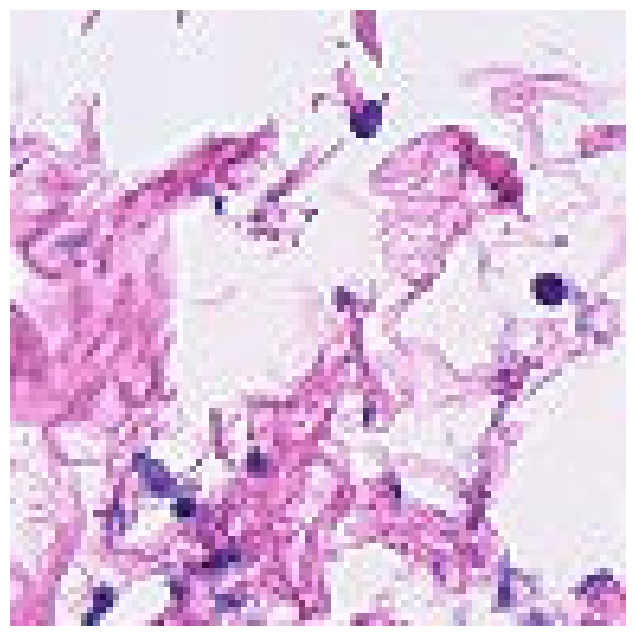

In [42]:
image = Image.open('./data/train/0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif')
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.show()

## EDA 

### Initial Conseriderations: Dataset Preview, Missing Data, Dataset Skew

#### 1. Dataset Preview
Important to take a look at a few samples of both positive and negative labels



In [43]:
#Load training dataset labels:
data_labels = pd.read_csv('./data/train_labels.csv')
data_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


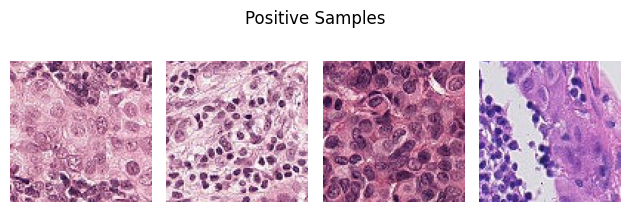

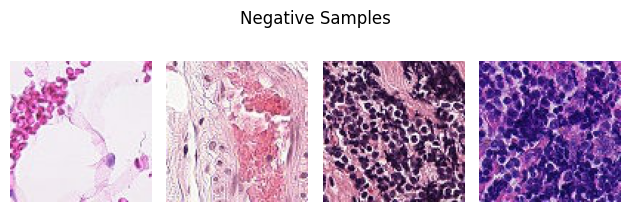

In [44]:
# Printing off some samples of both positive and negative cases
num_samples = 4

positive_samples = data_labels.loc[data_labels['label'] == 1].sample(num_samples)
negative_samples = data_labels.loc[data_labels['label'] == 0].sample(num_samples)

fig, axes = plt.subplots(1, num_samples)
for idx, a in enumerate(axes):
    image = Image.open('./data/train/' + positive_samples.iloc[idx]['id'] + '.tif')
    a.imshow(image)
    a.axis('off')
fig.suptitle("Positive Samples", y=.72)
plt.tight_layout()

fig, axes = plt.subplots(1, num_samples)
for idx, a in enumerate(axes):
    image = Image.open('./data/train/' + negative_samples.iloc[idx]['id'] + '.tif')
    a.imshow(image)
    a.axis('off')
fig.suptitle("Negative Samples", y=.72)
plt.tight_layout()



#### 2. Missing Data
Quick Check on the Images and CSV to ensure that all images have associated labels. 


In [45]:
# Missing Data Check

# First to see if there are any non-labeled ids:
print("Check to see if data labels have any missing data\n", data_labels.isna().sum())
# No missing labels at least in the csv

# Check to see if all labels in the csv have a matching .tif
# Extract all expected file paths from the labels DataFrame
label_ids = data_labels['id'].tolist()
missing_files = []
# Check for each label if the corresponding .tif file exists
for label_id in label_ids:
    image_path = os.path.join('./data/train', f"{label_id}.tif")
    if not os.path.exists(image_path):
        missing_files.append(label_id)

print('Number of missing tif files:', len(missing_files))

Check to see if data labels have any missing data
 id       0
label    0
dtype: int64
Number of missing tif files: 0


#### 3. Dataset Skew
Our training dataset may have a large amount of either positive or negative classifying cases. This skew may need to be addressed to get better model performance.


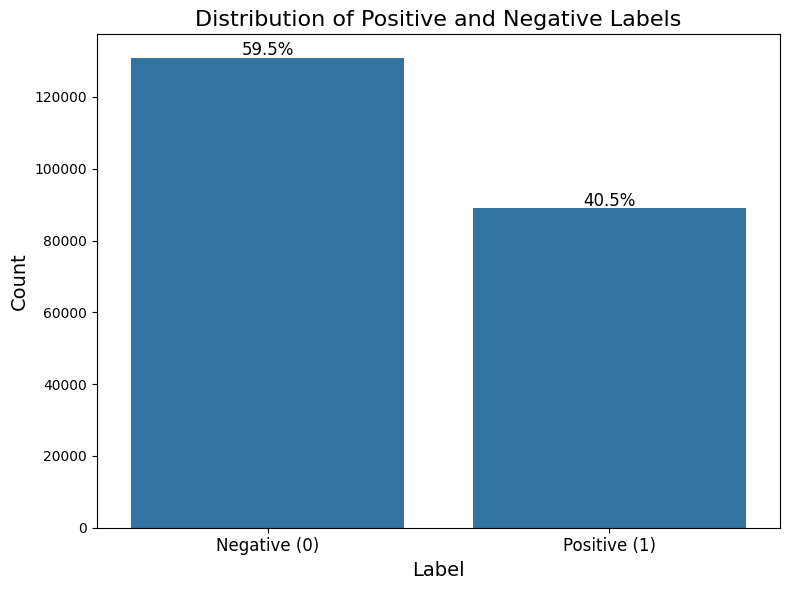

In [46]:
# Extract label counts and percentages
label_counts = data_labels['label'].value_counts()
total_samples = len(data_labels)
percentages = (label_counts / total_samples) * 100


plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)

# Annotate percentages on the bars
for i, (count, percentage) in enumerate(zip(label_counts.values, percentages)):
    plt.text(i, count*1.005, f"{percentage:.1f}%", ha='center', fontsize=12)

plt.title("Distribution of Positive and Negative Labels", fontsize=16)
plt.xlabel("Label", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(ticks=[0, 1], labels=["Negative (0)", "Positive (1)"], fontsize=12)
plt.tight_layout()

plt.show()


## Description of Model
The data provided seems to be of good quality. There is no missing labels, and the dataset skew isn't too bad. Just by looking at the positive and negative samples, I am unable to tell which categories the images belong to. I'll start the investigation process by building a simple CNN model, of type (CNN CNN Maxpool) * n --> Dense Classifier. I'll set n arbitrarily to 3 at the start, and will allow this to be tweaked as I refine the model. 


To start, I will use CNNs layers with 64 filters, then down to 32, and the final CNN layer will have 16. Since early CNN layers pick up the most basic features of a dataset, having plenty of these will hopefully allow the later stages to combine these basic features into more complex ones that will have a better indication on the outcome. 


Afterwards the classifier will be two dense layers of 128 and then 64 nodes, and one output node.

All hidden layers will make use of the ReLu activation function, and the output layer will be a sigmoid activation since this is a classifier type problem.




In [47]:
basic_model = tf.keras.Sequential([
    tf.keras.Input(shape=(96, 96, 3)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(8, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(8, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')


])
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.92,
    staircase=True)

basic_model.summary()
basic_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=['accuracy'] 
)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 conv2d_19 (Conv2D)          (None, 92, 92, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 46, 46, 32)       0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 44, 44, 16)        4624      
                                                                 
 conv2d_21 (Conv2D)          (None, 42, 42, 16)        2320      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 21, 21, 16)       0         
 g2D)                                                 

In [48]:
# Dataset Maker
# Path to the folder containing the .tif images
image_folder = "./data/train/"

# Function to load image
def load_image(image_id):
    image_path = os.path.join(image_folder, f"{image_id}.tif")
    image = Image.open(image_path)
    return tf.convert_to_tensor(image, dtype=tf.float32) / 255.0 

# Function to process an ID and label
def process_row(row):
    image = load_image(row['id'])
    label = tf.convert_to_tensor(int(row['label']), dtype=tf.int32)
    return image, label

    # Create a list of tuples (id, label) from the dataframe
data = list(zip(data_labels['id'], data_labels['label']))

# Create a TensorFlow Dataset
def generator():
    for id_, label in data:
        yield load_image(id_), tf.convert_to_tensor(int(label), dtype=tf.int32)

# Create the tf.data.Dataset
dataset = tf.data.Dataset.from_generator(
    generator,
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),  # Adjust channels if grayscale
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)

BATCH_SIZE = 32
shuffled_dataset = dataset.shuffle(buffer_size=1000, seed=7) # Shuffle dataset


validation_split = 0.2  # 20% for validation
train_split = 1 - validation_split
dataset_size = len(data_labels)  # Number of samples in the dataset
train_size = int(train_split * dataset_size)
validation_size = dataset_size - train_size

train_dataset = shuffled_dataset.take(train_size)
validation_dataset = shuffled_dataset.skip(train_size)

# Optional: Batch the datasets (if not already batched)
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [49]:

basic_hist = basic_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10
)


Epoch 1/10
5501/5501 [==============================] - 398s 72ms/step - loss: 0.4543 - accuracy: 0.7891 - val_loss: 0.4136 - val_accuracy: 0.8146
Epoch 2/10
5501/5501 [==============================] - 406s 74ms/step - loss: 0.3944 - accuracy: 0.8255 - val_loss: 0.3869 - val_accuracy: 0.8309
Epoch 3/10
5501/5501 [==============================] - 445s 80ms/step - loss: 0.3627 - accuracy: 0.8415 - val_loss: 0.3485 - val_accuracy: 0.8500
Epoch 4/10
5501/5501 [==============================] - 414s 75ms/step - loss: 0.3462 - accuracy: 0.8498 - val_loss: 0.3382 - val_accuracy: 0.8547
Epoch 5/10
5501/5501 [==============================] - 411s 74ms/step - loss: 0.3365 - accuracy: 0.8551 - val_loss: 0.3401 - val_accuracy: 0.8537
Epoch 6/10
5501/5501 [==============================] - 387s 70ms/step - loss: 0.3306 - accuracy: 0.8579 - val_loss: 0.3317 - val_accuracy: 0.8570
Epoch 7/10
5501/5501 [==============================] - 390s 71ms/step - loss: 0.3275 - accuracy: 0.8596 - val_loss: 0

After doing 3 epochs of this basic model, it is clear that the desired accuracy is not being achieved, and further training epochs are resulting in minimal gains. The model is massively underfitting the training data. In order to improve model performance, it is clear that the model complexity will need to be increased. This can be done by adding more layers (going deeper), adding more nuerons in a layer, or changing the architecure. For now, let's add another set of convolutional layers (2 Convolutions, 1 MAX Pool), and check how the model reacts.

In [50]:
basic_model_deeper = tf.keras.Sequential([
    tf.keras.Input(shape=(96, 96, 3)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),


    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),


    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')


])


basic_model_deeper.summary()
basic_model_deeper.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=['accuracy'] 
)



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 conv2d_25 (Conv2D)          (None, 92, 92, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 46, 46, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 44, 44, 32)        9248      
                                                                 
 conv2d_27 (Conv2D)          (None, 42, 42, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 21, 21, 32)       0         
 g2D)                                                 

In [51]:
basic_model_deeper_hist = basic_model_deeper.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10
)


Epoch 1/10
5501/5501 [==============================] - 394s 71ms/step - loss: 0.4678 - accuracy: 0.7807 - val_loss: 0.4287 - val_accuracy: 0.8064
Epoch 2/10
5501/5501 [==============================] - 387s 70ms/step - loss: 0.4068 - accuracy: 0.8198 - val_loss: 0.3778 - val_accuracy: 0.8355
Epoch 3/10
5501/5501 [==============================] - 386s 70ms/step - loss: 0.3707 - accuracy: 0.8400 - val_loss: 0.3770 - val_accuracy: 0.8408
Epoch 4/10
5501/5501 [==============================] - 386s 70ms/step - loss: 0.3513 - accuracy: 0.8492 - val_loss: 0.3403 - val_accuracy: 0.8541
Epoch 5/10
5501/5501 [==============================] - 388s 70ms/step - loss: 0.3398 - accuracy: 0.8540 - val_loss: 0.3382 - val_accuracy: 0.8549
Epoch 6/10
5501/5501 [==============================] - 387s 70ms/step - loss: 0.3322 - accuracy: 0.8579 - val_loss: 0.3292 - val_accuracy: 0.8591
Epoch 7/10
5501/5501 [==============================] - 386s 70ms/step - loss: 0.3271 - accuracy: 0.8605 - val_loss: 0

Even with the Deeper architecture, the resulting gains are not of the order to be expected. This indicates that there is some sort of bottleneck preventing the model from learning the correct the behaviour. This is likely due to the compression of information as information flows from the Convolutional part of the model. Even with almost 4 times the amount of parameters, this model isn't even arguably better. So instead of going deeper, let's go wider.

In [52]:
basic_model_wider= tf.keras.Sequential([
    tf.keras.Input(shape=(96, 96, 3)),
    
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),


    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')


])


basic_model_wider.summary()
basic_model_wider.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=['accuracy'] 
)



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 94, 94, 128)       3584      
                                                                 
 conv2d_33 (Conv2D)          (None, 92, 92, 128)       147584    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 46, 46, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 44, 44, 64)        73792     
                                                                 
 conv2d_35 (Conv2D)          (None, 42, 42, 64)        36928     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 21, 21, 64)       0         
 g2D)                                                 

In [53]:
basic_model_wider_hist = basic_model_wider.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10
)

Epoch 1/10
5501/5501 [==============================] - 424s 76ms/step - loss: 0.4171 - accuracy: 0.8117 - val_loss: 0.3456 - val_accuracy: 0.8476
Epoch 2/10
5501/5501 [==============================] - 425s 77ms/step - loss: 0.2981 - accuracy: 0.8747 - val_loss: 0.2655 - val_accuracy: 0.8923
Epoch 3/10
5501/5501 [==============================] - 421s 76ms/step - loss: 0.2411 - accuracy: 0.9030 - val_loss: 0.2795 - val_accuracy: 0.8855
Epoch 4/10
5501/5501 [==============================] - 422s 76ms/step - loss: 0.2168 - accuracy: 0.9140 - val_loss: 0.2204 - val_accuracy: 0.9132
Epoch 5/10
5501/5501 [==============================] - 419s 76ms/step - loss: 0.2017 - accuracy: 0.9206 - val_loss: 0.1937 - val_accuracy: 0.9256
Epoch 6/10
5501/5501 [==============================] - 419s 76ms/step - loss: 0.1920 - accuracy: 0.9252 - val_loss: 0.1932 - val_accuracy: 0.9246
Epoch 7/10
5501/5501 [==============================] - 420s 76ms/step - loss: 0.1855 - accuracy: 0.9279 - val_loss: 0

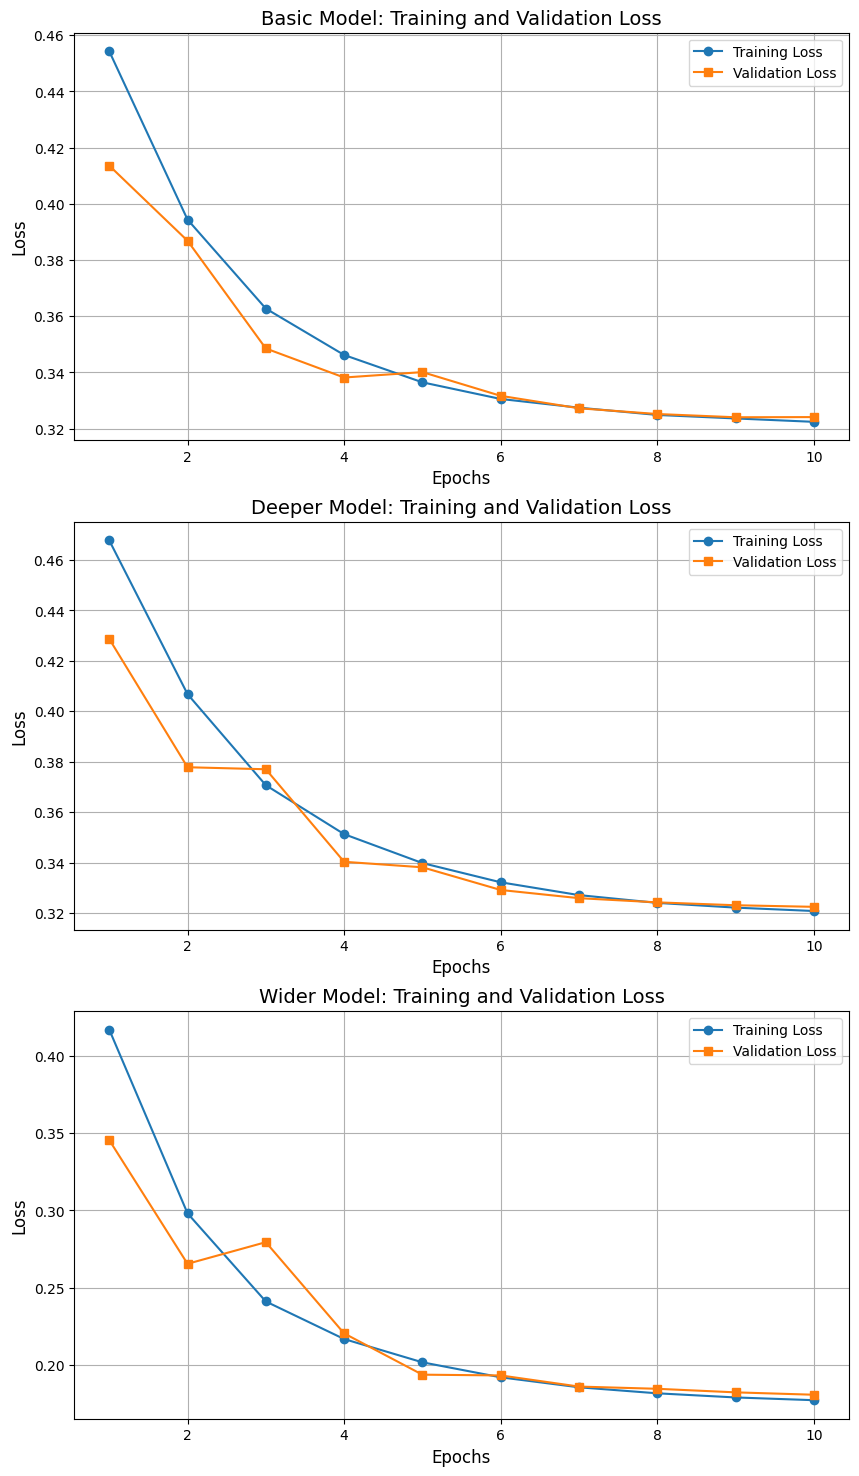

In [59]:
# Plots of all 3 Models

epochs = range(1, 11)




# Create a figure with 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

axs[0].plot(epochs, basic_hist.history['loss'], label='Training Loss', marker='o')
axs[0].plot(epochs, basic_hist.history['val_loss'], label='Validation Loss', marker='s')
axs[0].set_title('Basic Model: Training and Validation Loss', fontsize=14)
axs[0].set_xlabel('Epochs', fontsize=12)
axs[0].set_ylabel('Loss', fontsize=12)
axs[0].legend(fontsize=10)
axs[0].grid(True)

# Plot for Model 2
axs[1].plot(epochs, basic_model_deeper_hist.history['loss'], label='Training Loss', marker='o')
axs[1].plot(epochs, basic_model_deeper_hist.history['val_loss'], label='Validation Loss', marker='s')
axs[1].set_title('Deeper Model: Training and Validation Loss', fontsize=14)
axs[1].set_xlabel('Epochs', fontsize=12)
axs[1].set_ylabel('Loss', fontsize=12)
axs[1].legend(fontsize=10)
axs[1].grid(True)

# Plot for Model 3
axs[2].plot(epochs, basic_model_wider_hist.history['loss'], label='Training Loss', marker='o')
axs[2].plot(epochs, basic_model_wider_hist.history['val_loss'], label='Validation Loss', marker='s')
axs[2].set_title('Wider Model: Training and Validation Loss', fontsize=14)
axs[2].set_xlabel('Epochs', fontsize=12)
axs[2].set_ylabel('Loss', fontsize=12)
axs[2].legend(fontsize=10)
axs[2].grid(True)

# Show the plot
plt.show()

All 3 models have good loss curves when comparing the training and validation losses. This is indicative of a good learning rate, as well as little overfitting. The wider model performs the best over the 10 training epochs reaching the minimum amount of loss. In order to achieve a good training curve, I set a variable learning rate as initially I was having large spikes in loss after a couple of training epochs. This is indicative of a learning rate that is too high. All the models could certainly be trained further, but since the wider one did the best, I will explore only that one further. The accuracy plot below illustrates that the plateu has not yet been fully reached.

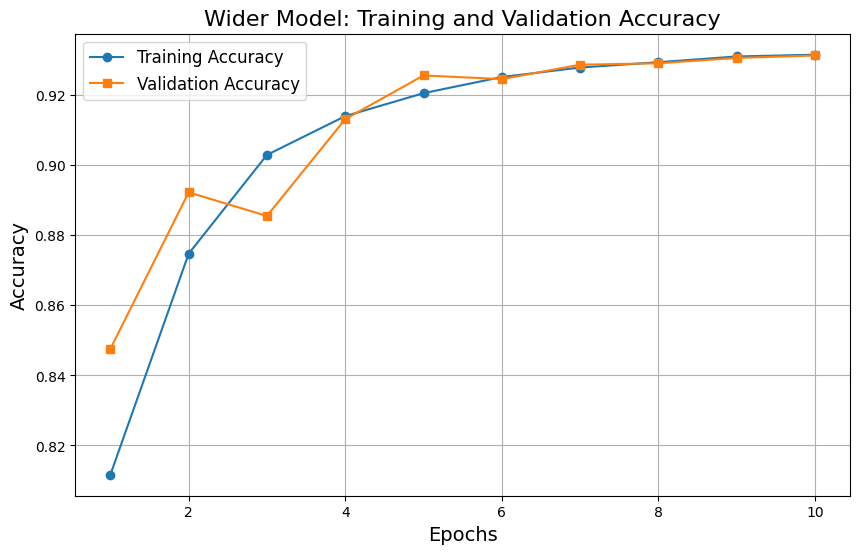

In [60]:
# Plot accuracy for Wider Model
plt.figure(figsize=(10, 6))

plt.plot(epochs, basic_model_wider_hist.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs, basic_model_wider_hist.history['val_accuracy'], label='Validation Accuracy', marker='s')

# Add titles and labels
plt.title('Wider Model: Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()

In [62]:
wider_hist = basic_model_wider.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,
    initial_epoch=10  # Start from epoch 10
)


Epoch 11/30
5501/5501 [==============================] - 599s 108ms/step - loss: 0.1761 - accuracy: 0.9321 - val_loss: 0.1805 - val_accuracy: 0.9309
Epoch 12/30
5501/5501 [==============================] - 453s 82ms/step - loss: 0.1753 - accuracy: 0.9324 - val_loss: 0.1805 - val_accuracy: 0.9311
Epoch 13/30
5501/5501 [==============================] - 437s 79ms/step - loss: 0.1750 - accuracy: 0.9325 - val_loss: 0.1803 - val_accuracy: 0.9315
Epoch 14/30
5501/5501 [==============================] - 440s 80ms/step - loss: 0.1745 - accuracy: 0.9327 - val_loss: 0.1797 - val_accuracy: 0.9315
Epoch 15/30
5501/5501 [==============================] - 439s 79ms/step - loss: 0.1744 - accuracy: 0.9328 - val_loss: 0.1797 - val_accuracy: 0.9315
Epoch 16/30
5501/5501 [==============================] - 430s 78ms/step - loss: 0.1744 - accuracy: 0.9329 - val_loss: 0.1795 - val_accuracy: 0.9313
Epoch 17/30
5501/5501 [==============================] - 426s 77ms/step - loss: 0.1741 - accuracy: 0.9329 - val

In [63]:
basic_model_wider.save('updated_model.h5')

In [66]:
wider_hist.history['accuracy']

[0.9320759177207947,
 0.9324224591255188,
 0.932530403137207,
 0.9327065348625183,
 0.9327576160430908,
 0.9328598976135254,
 0.9329167008399963,
 0.9329280853271484,
 0.9328996539115906,
 0.9329564571380615,
 0.9328883290290833,
 0.9328315258026123,
 0.9328144788742065,
 0.9328428506851196,
 0.932837188243866,
 0.932837188243866,
 0.9328428506851196,
 0.9328485131263733,
 0.9328315258026123,
 0.9328485131263733]

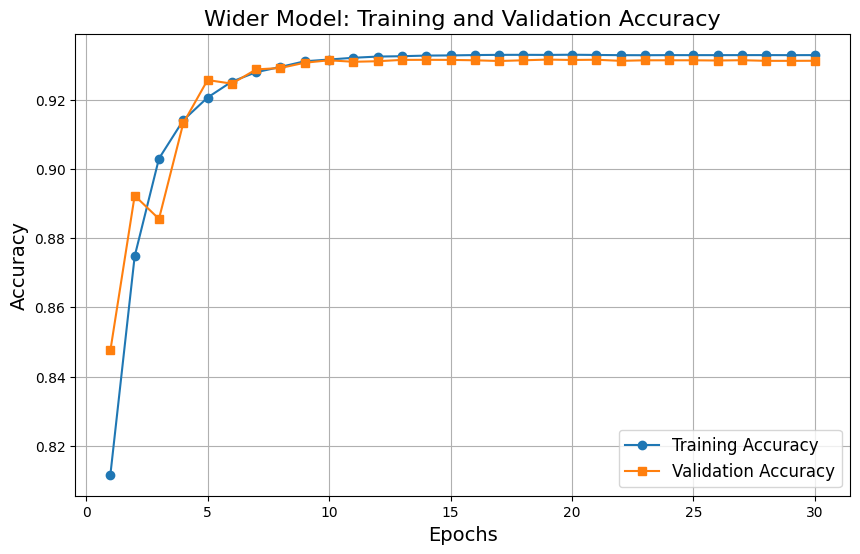

In [67]:
epochs = range(1, 31)
# Plot accuracy for Wider Model
plt.figure(figsize=(10, 6))

wider_acc = basic_model_wider_hist.history['accuracy']
wider_acc.extend(wider_hist.history['accuracy'])

wider_val_acc = basic_model_wider_hist.history['val_accuracy']
wider_val_acc.extend(wider_hist.history['val_accuracy'])

plt.plot(epochs, wider_acc, label='Training Accuracy', marker='o')
plt.plot(epochs, wider_val_acc, label='Validation Accuracy', marker='s')

# Add titles and labels
plt.title('Wider Model: Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()

In [104]:
# Prediction on the test dataset
test_image_folder = "./data/test/"

# Function to load and preprocess an image
def load_test_image(image_path):
    image = Image.open(image_path)
    return tf.convert_to_tensor(image, dtype=tf.float32) / 255.0  # Normalize

# List only .tif files in the test image folder
test_image_paths = [
    os.path.join(test_image_folder, file_name)
    for file_name in os.listdir(test_image_folder)
    if file_name.lower().endswith('.tif')  # Case-insensitive filter for .tif files
]

# Create a generator for test images
def test_generator():
    for image_path in test_image_paths:
        yield load_test_image(image_path), os.path.basename(image_path)  # Include file names for reference

# Create the tf.data.Dataset for the test set
test_dataset = tf.data.Dataset.from_generator(
    test_generator,
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),  # Adjust shape for your dataset
        tf.TensorSpec(shape=(), dtype=tf.string)  # File names as identifiers
    )
).batch(32, drop_remainder=False)  # Batch size for prediction



# Predict test images
predictions = basic_model_wider.predict(test_dataset.map(lambda img, _: img))  # Pass only images for prediction



1796/1796 [==============================] - 99s 55ms/step


In [113]:
binary_predictions = (predictions > 0.5).astype(int)  # Maps >0.5 to 1, otherwise 0

unbatched_results = []

for _, filenames in test_dataset.as_numpy_iterator():
    unbatched_results.extend(filenames)
# Associate predictions with image file names
decoded_results = [s.decode("utf-8").split('.')[0] for s in unbatched_results]



results = {"id": decoded_results, "label": binary_predictions.flatten().tolist()}

# Convert to a DataFrame
results_df = pd.DataFrame(results, columns=["id", "label"])

# Save to a CSV file with the desired header
results_df.to_csv("test_predictions.csv", index=False, encoding="utf-8")